In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

In [38]:
# Data Loading and Initial Exploration
df = pd.read_csv('retail_price.csv')
df.head()

,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,...,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
0,bed1,bed_bath_table,01-05-2017,1,45.95,15.100000,45.95,39,161,2,...,89.9,3.9,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,45.90
1,bed1,bed_bath_table,01-06-2017,3,137.85,12.933333,45.95,39,161,2,...,89.9,3.9,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,45.95
2,bed1,bed_bath_table,01-07-2017,6,275.70,14.840000,45.95,39,161,2,...,89.9,3.9,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,45.95
3,bed1,bed_bath_table,01-08-2017,4,183.80,14.287500,45.95,39,161,2,...,89.9,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,45.95
4,bed1,bed_bath_table,01-09-2017,2,91.90,15.100000,45.95,39,161,2,...,89.9,3.9,18.776522,163.398710,4.4,24.324687,45.95,4.0,15.100000,45.95


**Dataset Column Descriptions**

This dataset encompasses various aspects of sales data, product information, and competitive market analysis. Below is an updated description of each column, incorporating additional context provided:

- `qty`: Quantity of the product sold or ordered.
- `total_price`: Total price paid for the order or product.
- `customers`: Number of customers involved in the transactions.
- `s`: Seasonality's Impact - Measures the impact of different seasons on the product's demand or popularity.
- `holiday`: Indicates if the sale occurred during a holiday.
- `product_photos_qty`: Number of photos available for the product.
- `product_name_lenght`: Length of the product name.
- `year`: Year when the sale or transaction occurred.
- `volume`: Volume of the product sold or shipped.
- `ps1`, `ps2`, `ps3`: Product Score or Rating Linked to Items From Rival Companies - Ratings or scores of rival products, reflecting quality or customer satisfaction.
- `weekday`: Day of the week when the transaction occurred.
- `product_score`: Score or rating given to the product.
- `month`: Month when the sale or transaction occurred.
- `product_description_lenght`: Length of the product's description.
- `comp_1`, `comp_2`, `comp_3`: Details or Variables About Rivals' Offers, Pricing, or Other Pertinent Elements - Data related to competitors, including pricing, offers, and market variables.
- `product_weight_g`: Weight of the product in grams.
- `fp1`, `fp2`, `fp3`: Freight or Shipment Costs Related to Items from Rivals - Costs associated with the shipping or freight of competitor products.
- `weekend`: Indicates if the sale occurred during the weekend.
- `lag_price`: Previous price of the product, for trend analysis and comparison.
- `unit_price`: Price per unit of the product.
- `freight_price`: Price of freight or shipping for the product.

In [39]:
# Data Preprocessing
df['month_year'] = pd.to_datetime(df['month_year'], format='%d-%m-%Y')
df.nunique()

product_id                     52
product_category_name           9
month_year                     20
qty                            66
total_price                   573
freight_price                 653
unit_price                    280
product_name_lenght            24
product_description_lenght     46
product_photos_qty              7
product_weight_g               45
product_score                  11
customers                      94
weekday                         4
weekend                         3
holiday                         5
month                          12
year                            2
s                             450
volume                         40
comp_1                         88
ps1                             9
fp1                           179
comp_2                        123
ps2                            10
fp2                           242
comp_3                        105
ps3                             9
fp3                           229
lag_price     

In [40]:
# Handling Null Values
null_percentage = (df.isnull().mean() * 100).round(2)
null_percentage_df = pd.DataFrame({'Column Name': null_percentage.index, 'Null Percentage': null_percentage.values})
print(null_percentage_df)

                   Column Name  Null Percentage
0                   product_id              0.0
1        product_category_name              0.0
2                   month_year              0.0
3                          qty              0.0
4                  total_price              0.0
5                freight_price              0.0
6                   unit_price              0.0
7          product_name_lenght              0.0
8   product_description_lenght              0.0
9           product_photos_qty              0.0
10            product_weight_g              0.0
11               product_score              0.0
12                   customers              0.0
13                     weekday              0.0
14                     weekend              0.0
15                     holiday              0.0
16                       month              0.0
17                        year              0.0
18                           s              0.0
19                      volume          

In [41]:
# Feature Categorization
continuous_features = []
binary_features = []
multinomial_features = []
categorical_features = []

# Determine feature categories
for column in df.columns:
    num_unique_values = df[column].nunique()
    if df[column].dtype in [int, float]:
        if num_unique_values > 2:
            if column not in ['Shipping Type', 'Frequency of Purchases','Season','Category']:
                continuous_features.append(column)
            else:
                multinomial_features.append(column)
        else:
            binary_features.append(column)
    elif num_unique_values == 2:
        binary_features.append(column)
    elif num_unique_values > 2 and num_unique_values <= 10:
        multinomial_features.append(column)
    else:
        categorical_features.append(column)

# Print the categorized feature lists
print("Continuous Features:", continuous_features)
print("Binary Features:", binary_features)
print("Multinomial Features:", multinomial_features)
print("Categorical Features:", categorical_features)

Continuous Features: ['qty', 'total_price', 'freight_price', 'unit_price', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_score', 'customers', 'weekday', 'weekend', 'holiday', 'month', 's', 'volume', 'comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2', 'comp_3', 'ps3', 'fp3', 'lag_price']
Binary Features: ['year']
Multinomial Features: ['product_category_name']
Categorical Features: ['product_id', 'month_year']


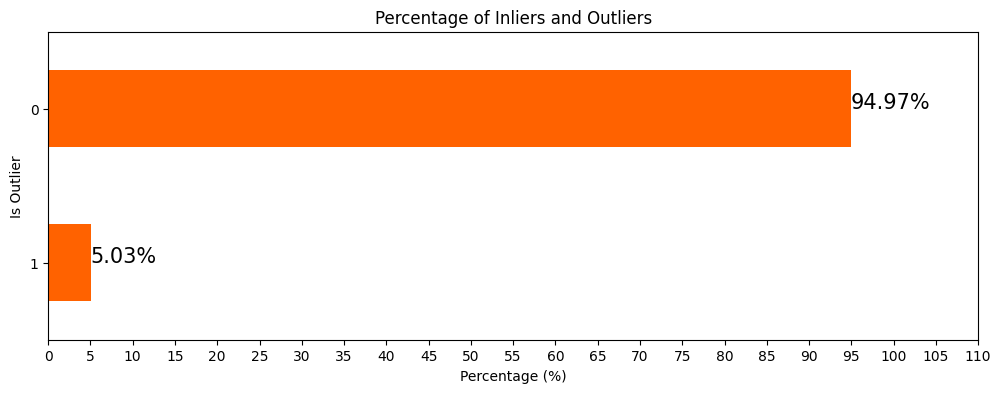

In [42]:
# Outlier Detection and Removal
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
df['Outlier_Scores'] = model.fit_predict(df[continuous_features].iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
df['Is_Outlier'] = [1 if x == -1 else 0 for x in df['Outlier_Scores']]

# Separate the outliers for analysis
outliers_data = df[df['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
df_cleaned = df[df['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
df_cleaned = df_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
df_cleaned.reset_index(drop=True, inplace=True)

# Calculate the percentage of inliers and outliers
outlier_percentage = df['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [43]:
# Revenue and Profit Calculation
df_cleaned["revenue"] = df_cleaned["qty"] * df_cleaned["total_price"]
df_cleaned["profit"] = df_cleaned["revenue"] - df_cleaned["freight_price"]

#Profit margin: indicates the percentage of revenue that is retained as profit after accounting for expenses.
df_cleaned["margin"] = (df_cleaned["profit"] / df_cleaned["revenue"]) * 100

# Price Ratios: These ratios help assess how the product's pricing compares to competitors. A ratio greater than 1 suggests the product is priced higher than the competitor's, while a ratio less than 1 suggests a lower price.
df_cleaned["price_ratio_1"] = df_cleaned["unit_price"] / df["comp_1"]
df_cleaned["price_ratio_2"] = df_cleaned["unit_price"] / df["comp_2"]
df_cleaned["price_ratio_3"] = df_cleaned["unit_price"] / df["comp_3"]

# Price DiffereDifference
df_cleaned["price_diff_1"] = df_cleaned["unit_price"] - df_cleaned["comp_1"]
df_cleaned["price_diff_2"] = df_cleaned["unit_price"] - df_cleaned["comp_2"]
df_cleaned["price_diff_3"] = df_cleaned["unit_price"] - df_cleaned["comp_3"]

# Monthly Sales and Profit Total
monthly_sales_total = df_cleaned.groupby("month_year")["revenue"].sum()
monthly_profit_total = df_cleaned.groupby("month_year")["profit"].sum()

# Profit Margin per Product
df_cleaned["product_profit_margin"] = (df_cleaned["profit"] / df_cleaned["revenue"]) * 100

# Price-to-Revenue Ratio and Average Quantity Sold per Month
df_cleaned["price_to_revenue_ratio"] = df_cleaned["unit_price"] / df_cleaned["revenue"]
avg_quantity_sold_per_month = df_cleaned.groupby("month_year")["qty"].mean()

# Total Sales per Product Category
total_sales_per_category = df_cleaned.groupby("product_category_name")["revenue"].sum()

# Financial Metrics Analysis


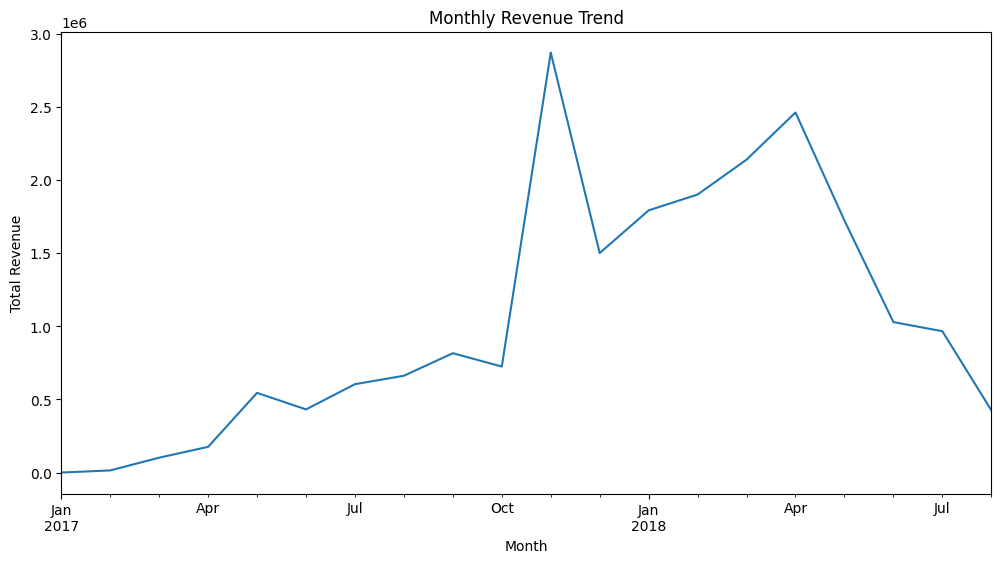

In [44]:
# Convert 'month_year' to datetime
df_cleaned['month_year'] = pd.to_datetime(df_cleaned['month_year'], format='%d-%m-%Y')

# 1. Revenue Trend Analysis
monthly_revenue = df_cleaned.groupby(df_cleaned['month_year'].dt.to_period('M'))['revenue'].sum()
plt.figure(figsize=(12, 6))
monthly_revenue.plot(title='Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.show()

### **Monthly Revenue Trend Analysis**

The line graph represents the monthly total revenue over an 18-month period. Several key observations can be made:

- **Growth Trend**: There is an overall upward trend in revenue from January 2017 to the end of the period, indicating growth over time.
- **Seasonal Peaks**: Notably, there are significant spikes in revenue at certain points, particularly around October 2017 and April 2018. These could correspond to seasonal events or successful marketing campaigns.
- **Mid-Year Dip**: Around July 2017, there is a noticeable dip in revenue, which could indicate seasonal downturns or external market factors affecting sales.
- **Year-Over-Year Increase**: Comparing the peaks of April 2017 and April 2018, there is a clear increase in revenue year over year, suggesting successful scaling or expanded market reach.
- **Declining Phase**: Post-April 2018, there is a decline in revenue leading into July 2018, which may warrant further investigation to understand underlying causes, such as market saturation, increased competition, or changes in consumer behavior.

### Implications for Business Strategy:
- **Marketing and Sales Planning**: Aligning sales strategies and marketing efforts with the apparent peak periods could capitalize on the existing consumer buying patterns.
- **Investigation of Dips**: Understanding the cause of the mid-year dip and the decline in the latter part could help in formulating strategies to mitigate these downturns in the future.
- **Product and Inventory Management**: Adjustments to inventory levels and product offerings can be timed to coincide with anticipated peaks to maximize revenue.

### Recommendations for Further Analysis:
- **Detailed Breakdown**: A more granular analysis could provide insights into which products or services are driving the peaks and troughs.
- **Causal Factors**: Investigating external factors such as economic indicators, competitor activity, or changes in consumer preferences during the observed periods.
- **Predictive Modeling**: Leveraging predictive analytics to forecast future revenue trends and identify potential opportunities or risks.

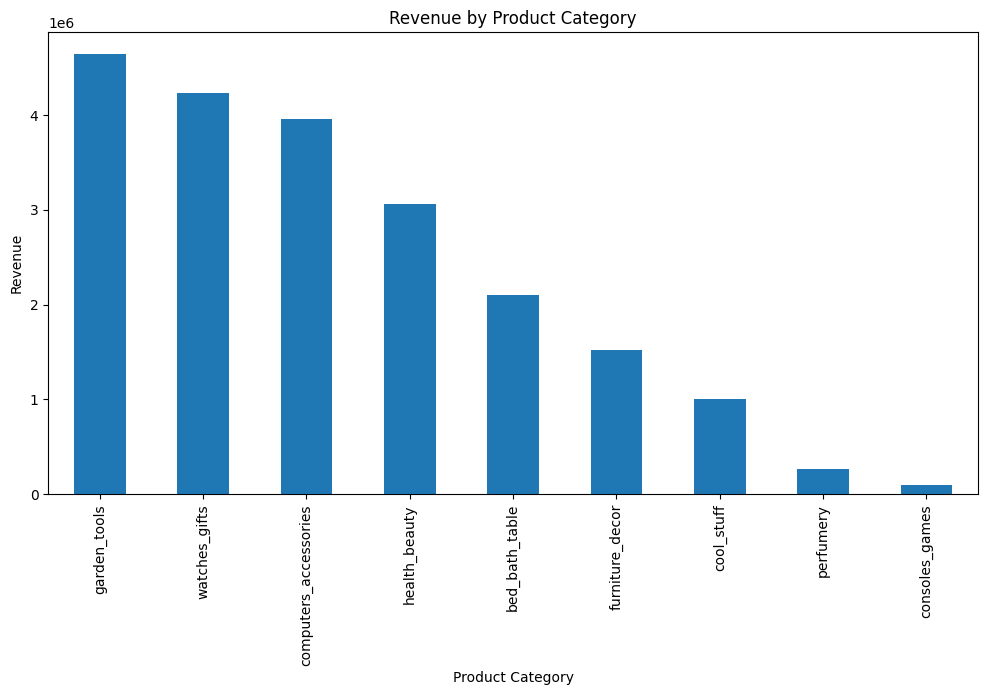

In [45]:
# Product Category Analysis
category_revenue = df_cleaned.groupby('product_category_name')['revenue'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
category_revenue.plot(kind='bar', title='Revenue by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Revenue')
plt.show()

### **Analysis of Revenue by Product Category**

The bar chart provides a visualization of revenue generated by different product categories. The following points can be observed from the chart:

- **Top Performing Categories**: 'Garden Tools', 'Watches_Gifts', and 'Computers_Accessories' are the top three categories, indicating strong sales performance in these segments.
- **Middle Performers**: 'Health_Beauty' and 'Bed_Bath_Table' show moderate revenue, which suggests a steady but lower demand compared to the top categories.
- **Lower Revenue Categories**: 'Furniture_Decor', 'Cool_Stuff', and 'Perfumery' generate relatively lower revenue, pointing to lesser sales or possibly higher competition in these areas.
- **Least Performing Category**: 'Consoles_Games' has the least revenue, signaling either a niche market, lack of demand, or strong competition affecting sales.

### Strategic Business Insights:
- **Investment Opportunities**: The data suggests potential for investing more resources in the top categories to maximize revenue, given their strong market performance.
- **Product Portfolio Diversification**: For middle and lower revenue-generating categories, diversifying the product range or implementing targeted marketing strategies could help boost sales.
- **Market Analysis for Lower Categories**: Understanding why some categories like 'Consoles_Games' have low revenue is crucial. It may be beneficial to conduct market research to understand consumer preferences or competitive dynamics.

### Recommendations for Action:
- **Marketing Focus**: Align marketing strategies to promote higher revenue categories during peak sales periods, and create targeted campaigns for categories needing a sales boost.
- **Stock Optimization**: Adjust inventory levels to ensure supply meets demand, particularly for the top-performing categories, to avoid stockouts or overstock situations.
- **Customer Engagement**: Engage with customers to gain insights into their preferences and satisfaction levels across different categories, which can inform product development and improvement.

### Further Analysis Required:
- **Profitability Assessment**: Revenue does not equate to profit. Analyzing the profit margins for these categories can provide a better understanding of their actual contribution to the business.
- **Trend Analysis**: Investigate sales trends over time within each category to determine if the current revenue snapshot is consistent with longer-term trends.
- **External Factors Impact**: Consider external factors such as seasonality, economic conditions, and market trends that might affect the revenue of these categories.



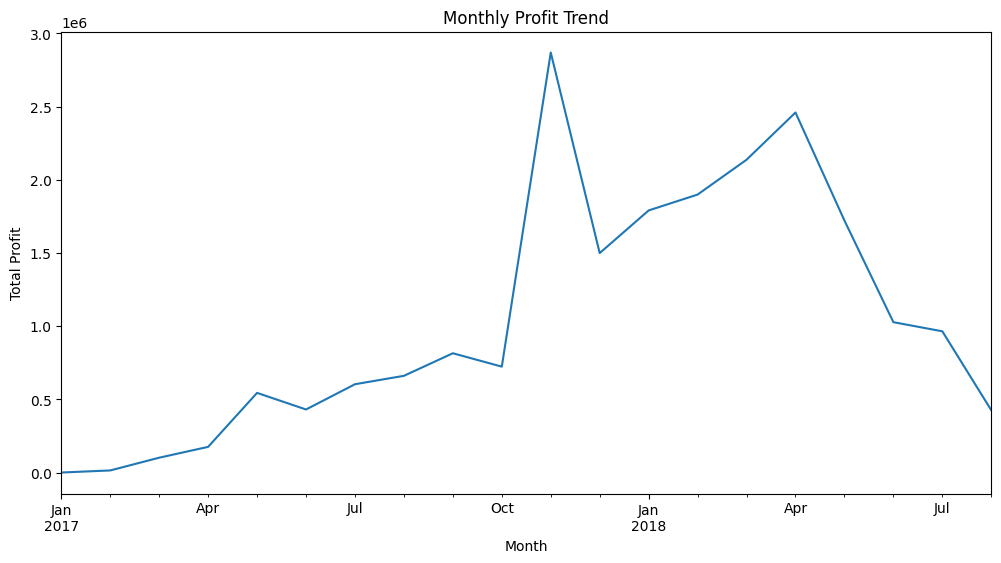

In [46]:
# Profit Analysis
monthly_profit = df_cleaned.groupby(df_cleaned['month_year'].dt.to_period('M'))['profit'].sum()
plt.figure(figsize=(12, 6))
monthly_profit.plot(title='Monthly Profit Trend')
plt.xlabel('Month')
plt.ylabel('Total Profit')
plt.show()

### **Monthly Profit Trend Analysis**

The line graph illustrates the trend in monthly profits over an 18-month period. We can deduce several points from the visualization:

- **Increasing Profit Trend**: There is a general increase in profit from January 2017, suggesting an improving profitability situation over time.
- **Significant Peaks**: The graph shows pronounced peaks, especially around October 2017 and March 2018. These could reflect high-performing sales periods or the result of specific profitable ventures or seasonal campaigns.
- **Dips in Profit**: There are also notable dips, particularly following the peaks, which could be attributed to a variety of factors, such as increased costs, seasonal downturns, or the end of a successful campaign.
- **Comparative Analysis**: While there's a general increase in profit year-over-year, the peaks are followed by sharp declines, indicating possible volatility in the profit margins.

### Strategic Implications for Business:
- **Resource Allocation**: Allocating resources effectively during peak profit months can help sustain and build upon these high-profit periods.
- **Cost Management**: Investigating the causes behind the sharp declines post-peak periods can provide insights into cost management and help in strategizing for more stable profit margins.
- **Strategic Planning**: The data can be used to plan for future business strategies, taking into account the timing of marketing campaigns and sales initiatives to capitalize on potential high-profit periods.

### Actions for Further Consideration:
- **Profit Margin Analysis**: Further examination of the cost structure and profit margins to understand what drives profitability in peak months versus what causes declines.
- **Seasonality Review**: A review of the effect of seasonality on the business can help in forecasting and preparing for fluctuations in profit.
- **Long-term Profitability**: Strategies should be developed not only to capitalize on peak profits but also to ensure long-term, stable profitability throughout the year.

### Further Analytical Steps:
- **Breakdown by Category**: Analyzing profit trends by individual product categories can provide more detailed insights into which areas are the most profitable.
- **Expense Analysis**: A detailed look at the expenses and cost of goods sold during different periods can help explain the profit trends observed.
- **Correlation with External Events**: Understanding how external events, market trends, and consumer behavior impact profitability can inform more resilient business strategies.


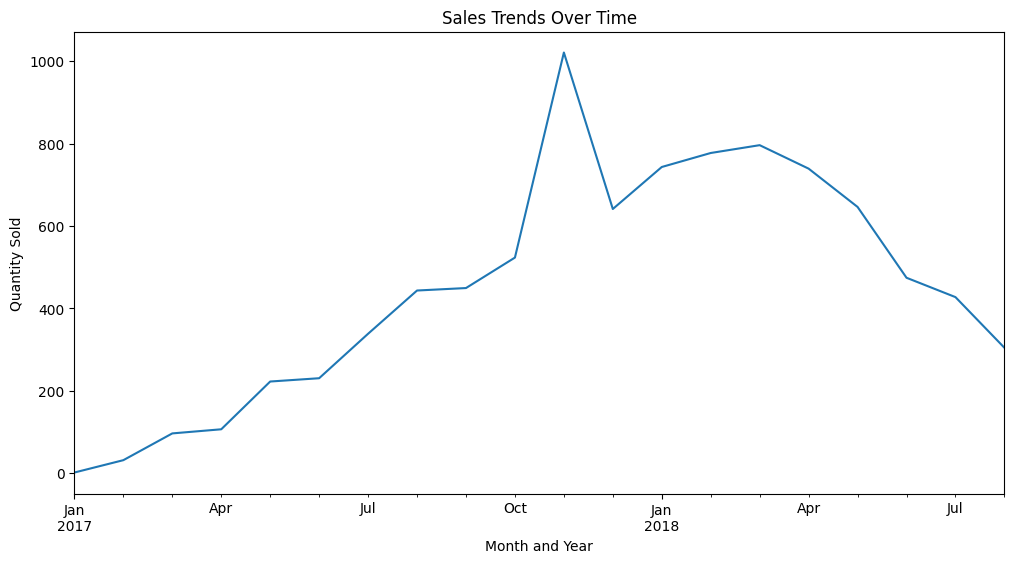

In [11]:
# Convert 'month_year' to datetime if it's not already
df_cleaned['month_year'] = pd.to_datetime(df_cleaned['month_year'])

# Analyze sales trends over time
sales_trends = df_cleaned.groupby('month_year')['qty'].sum()

plt.figure(figsize=(12, 6))
sales_trends.plot()
plt.title('Sales Trends Over Time')
plt.xlabel('Month and Year')
plt.ylabel('Quantity Sold')
plt.show()

### **Sales Trends Over Time Analysis**

The provided line graph illustrates the quantity of products sold each month over an 18-month period, giving insights into sales performance and trends.

## Observations:
- There is a general upward trend in sales from January 2017 to October 2017, indicating a period of growth.
- A sharp peak occurs around October 2017, which could suggest a successful sales initiative or a seasonal surge in demand.
- Post-October 2017, there is a significant drop, which may reflect a return to normal sales levels after a peak season or the end of a sales event.
- Another increase in sales is observed around the beginning of 2018, followed by a gradual decline leading into July 2018.

## Business Insights:
- The graph may point to seasonal patterns, with peaks possibly representing holiday or special event-driven sales increases.
- The decline phases could be opportunities to evaluate and improve sales strategies to maintain consistent performance throughout the year.

## Further Analysis:
- A detailed analysis could be conducted to correlate sales spikes with specific marketing campaigns, holidays, or other events.
- A comparison with cost data could help determine the profitability of sales during peak periods.
- Customer segmentation and analysis might reveal which demographics are driving the sales trends observed.

## Conclusion:
This visual analysis of sales data is critical for making informed decisions regarding marketing strategies, inventory planning, and overall sales management. Understanding these patterns can help predict future trends and adjust business strategies accordingly.



# Exploratory Data Analysis (EDA)

In [12]:
# Summary statistics
# Create a DataFrame with only the numerical columns
numerical_df = df[continuous_features]

# Generate summary statistics for numerical columns
summary_stats = numerical_df.describe().round(2)
summary_stats

,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_score,customers,...,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
count,676.00,676.00,676.00,676.00,676.00,676.00,676.00,676.00,676.00,676.00,...,676.00,676.00,676.00,676.00,676.00,676.00,676.00,676.00,676.00,676.00
mean,14.50,1422.71,20.68,106.50,48.72,767.40,1.99,1847.50,4.09,81.03,...,79.45,4.16,18.60,92.93,4.12,18.62,84.18,4.00,17.97,107.40
std,15.44,1700.12,10.08,76.18,9.42,655.21,1.42,2274.81,0.23,62.06,...,47.93,0.12,9.41,49.48,0.21,6.42,47.75,0.23,5.53,76.97
min,1.00,19.90,0.00,19.90,29.00,100.00,1.00,100.00,3.30,1.00,...,19.90,3.70,0.10,19.90,3.30,4.41,19.90,3.50,7.67,19.85
25%,4.00,333.70,14.76,53.90,40.00,339.00,1.00,348.00,3.90,34.00,...,49.91,4.10,13.83,53.90,4.10,14.48,53.79,3.90,15.04,55.67
50%,10.00,807.89,17.52,89.90,51.00,501.00,1.50,950.00,4.10,62.00,...,69.90,4.20,16.62,89.99,4.20,16.81,59.90,4.00,16.52,89.90
75%,18.00,1887.32,22.71,129.99,57.00,903.00,2.00,1850.00,4.20,116.00,...,104.26,4.20,19.73,117.89,4.20,21.67,99.99,4.10,19.45,129.99
max,122.00,12095.00,79.76,364.00,60.00,3006.00,8.00,9750.00,4.50,339.00,...,349.90,4.50,57.23,349.90,4.40,57.23,255.61,4.40,57.23,364.00


# Statistical Summary of Retail Dataset

The dataset consists of several metrics indicative of retail sales performance, product details, and competitive benchmarking. Below is a statistical summary of the key columns:

- `qty`: Reflects the quantity of products sold. The average quantity sold is approximately 14.5 units, with a broad range indicating varied sales volume across products.

- `total_price`: Represents the total transaction value. The average transaction amounts to roughly 1422.71, highlighting significant transaction value diversity, up to a maximum of 12095.

- `freight_price`: Denotes the shipping cost associated with transactions. On average, shipping costs are 20.68, with some orders costing as much as 79.76 to ship.

- `unit_price`: The average selling price per unit stands at 106.50, with a wide price range, suggesting a diverse assortment of products.

- `product_name_lenght`: The average length of product names is 48.72 characters, with the longest at 60 characters.

- `product_description_lenght`: Product descriptions average at 767.40 characters, pointing to a substantial amount of detail provided to customers, with some descriptions reaching up to 3006 characters.

- `product_photos_qty`: Indicates the average number of photos available per product is nearly 2, facilitating a visually informed purchase decision.

- `product_weight_g`: The average product weight is 1847.50 grams, with a large variation that spans from light to heavy items.

- `product_score`: Average product rating is a favorable 4.09, suggesting generally positive customer feedback.

- `customers`: Indicates an average customer count of 81.03, which may signal repeat purchases or bulk buying behaviors.

Competitive metrics provide insight into how the company's products stack up against rivals:

- `comp_1`, `comp_2`, `comp_3`: Average competitor prices are 79.45, 92.93, and 84.18 respectively, which are vital for comparative market analysis.

- `ps1`, `ps2`, `ps3`: Average competitor product scores are 4.16, 4.12, and 4.00, respectively, which are in the same range as the company's product score.

- `fp1`, `fp2`, `fp3`: Reflects competitors' average freight prices, which are comparable to the company's freight cost, suggesting a competitive shipping pricing strategy.

- `lag_price`: The lagged price, possibly representing the product's previous pricing, averages at 107.40.

The dataset provides a comprehensive view of the company's operational metrics and can be leveraged to drive data-informed strategies. Detailed analysis of these figures can highlight areas of strength and opportunities for improvement within the product offerings and operational efficiencies.


<ipython-input-16-2373cd2e6f0c>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(correlation_matrix, dtype=np.bool)


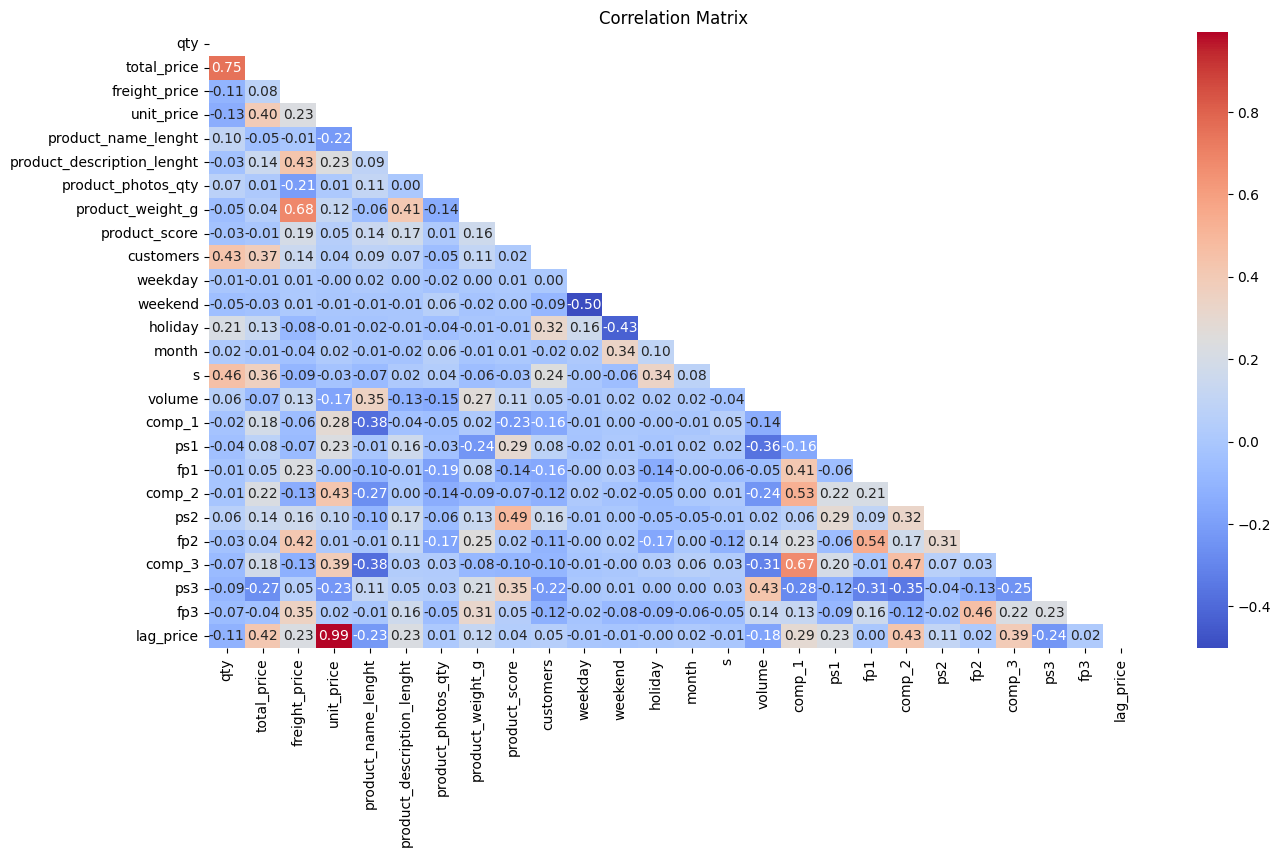

Columns 'total_price' and 'qty' are highly correlated with a correlation of 0.75.
Columns 'unit_price' and 'total_price' are moderately correlated with a correlation of 0.40.
Columns 'unit_price' and 'freight_price' are moderately correlated with a correlation of 0.23.
Columns 'product_name_lenght' and 'unit_price' are moderately correlated with a correlation of -0.22.
Columns 'product_description_lenght' and 'freight_price' are moderately correlated with a correlation of 0.43.
Columns 'product_description_lenght' and 'unit_price' are moderately correlated with a correlation of 0.23.
Columns 'product_photos_qty' and 'freight_price' are moderately correlated with a correlation of -0.21.
Columns 'product_weight_g' and 'freight_price' are highly correlated with a correlation of 0.68.
Columns 'product_weight_g' and 'product_description_lenght' are moderately correlated with a correlation of 0.41.
Columns 'customers' and 'qty' are moderately correlated with a correlation of 0.43.
Columns 'c

In [16]:
#Correlation analysis

# Compute the correlation matrix
correlation_matrix = df_cleaned[continuous_features].corr()

# Create a mask to hide the upper triangle for better visualization
mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
plt.figure(figsize=(15, 8))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)

plt.title("Correlation Matrix")
plt.show()

# Add lines to detect columns that are correlated
correlated_columns = set()
threshold_high = 0.5  # Threshold for highly correlated
threshold_moderate = 0.2  # Threshold for moderately correlated

# Iterate through the correlation matrix
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        correlation_value = correlation_matrix.iloc[i, j]
        col1 = correlation_matrix.columns[i]
        col2 = correlation_matrix.columns[j]

        if abs(correlation_value) > threshold_high:
            print(f"Columns '{col1}' and '{col2}' are highly correlated with a correlation of {correlation_value:.2f}.")
        elif abs(correlation_value) > threshold_moderate:
            print(f"Columns '{col1}' and '{col2}' are moderately correlated with a correlation of {correlation_value:.2f}.")

# Correlation Analysis of Retail Dataset

Correlations between different variables in the dataset are crucial for understanding relationships and dependencies. Here we highlight several notable correlations:

## Strong Correlations:
- `total_price` and `qty`: High correlation (0.75) suggests that total revenue increases significantly with the quantity of items sold.
- `product_weight_g` and `freight_price`: A correlation of 0.68 indicates that heavier products tend to have higher shipping costs.
- `lag_price` and `unit_price`: Almost perfect correlation (0.99), likely indicating that the lag price closely tracks the current unit price.

## Moderate Correlations:
- `unit_price` and `total_price`: Correlation of 0.40 indicates a moderate relationship between the selling price per unit and the total revenue.
- `product_description_lenght` and `freight_price`: A correlation of 0.43 may suggest that products with longer descriptions, possibly larger or more complex, have higher shipping costs.
- `customers` and `qty`: A correlation of 0.43 implies that as more customers make purchases, the quantity of products sold increases.

## Negative Correlations:
- `product_name_lenght` and `unit_price`: A negative correlation (-0.22) could indicate that longer product names are associated with lower prices.
- `holiday` and `weekend`: The negative correlation (-0.43) likely reflects the mutual exclusivity of these two variables in a weekly cycle.

## Correlations Among Competitor Metrics:
- `comp_1`, `comp_2`, and `comp_3` show significant positive correlations with each other (up to 0.67), which suggests that competitors may have similar pricing strategies.
- `ps2` and `product_score`: A correlation of 0.49 points to a strong relationship between the product scores of the company and its competitors.

## Implications for Machine Learning Models:
Understanding these correlations is essential when building predictive models:
- **Multicollinearity**: High correlations among features, such as `lag_price` and `unit_price`, can lead to multicollinearity, which may distort the performance of some machine learning models.
- **Feature Selection**: Moderately correlated features with the target variable, like `customers` and `qty`, can be good predictors and should be considered for model training.
- **Data Preprocessing**: Negative correlations suggest that some data transformations or feature engineering may be required to capture the true relationship between certain variables.

## Recommendations for Data Analysis:
- **Investigate Causality**: Correlation does not imply causation. Further analysis, such as controlled experiments or causal inference methods, is needed to establish causality.
- **Temporal Dynamics**: With data like `lag_price`, consider time series analysis to understand how prices evolve and influence sales over time.
- **Customer Behavior Analysis**: The correlation between `customers` and `qty` warrants a deeper dive into customer purchase patterns and behavior.

By considering these correlations, we can gain deeper insights into the dataset and ensure that any analytical models built on this data are robust and reliable.


In [13]:
granger_test_result = grangercausalitytests(df_cleaned[['qty', 'total_price']], maxlag=2, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6064  , p=0.4364  , df_denom=638, df_num=1
ssr based chi2 test:   chi2=0.6093  , p=0.4351  , df=1
likelihood ratio test: chi2=0.6090  , p=0.4352  , df=1
parameter F test:         F=0.6064  , p=0.4364  , df_denom=638, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5780  , p=0.5613  , df_denom=635, df_num=2
ssr based chi2 test:   chi2=1.1652  , p=0.5584  , df=2
likelihood ratio test: chi2=1.1641  , p=0.5587  , df=2
parameter F test:         F=0.5780  , p=0.5613  , df_denom=635, df_num=2


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


## Granger Causality Test Results

We performed the Granger Causality test to explore potential predictability between two time series variables. The results are as follows:

- With one lag, the p-values for both the F-test and the chi-squared test were above 0.05 (F=0.6064, p=0.4364), suggesting no Granger causality.
- With two lags, the results were similar, with p-values remaining above 0.05 (F=0.5780, p=0.5613), again indicating no Granger causality.

## Conclusion:
The tests conducted with one and two lags do not provide sufficient evidence to conclude that there is a causal predictive relationship between the time series variables under consideration. This implies that past values of one variable do not have a statistically significant effect on the future values of the other variable within this dataset.


In [47]:
# Predictive Sales Forecasting Model

df_cleaned.drop('product_id', axis=1, inplace= True)

# One-hot encoding for the 'product_category_name' categorical variable
df_encoded = pd.get_dummies(df_cleaned, columns=['product_category_name'])

# Define the feature set 'X' and the target variable 'y'
X = df_encoded.drop(columns=['qty', 'month_year'])
y = df_encoded['qty']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Display the DataFrame to check the encoding
df_encoded.head()

,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_score,...,price_to_revenue_ratio,product_category_name_bed_bath_table,product_category_name_computers_accessories,product_category_name_consoles_games,product_category_name_cool_stuff,product_category_name_furniture_decor,product_category_name_garden_tools,product_category_name_health_beauty,product_category_name_perfumery,product_category_name_watches_gifts
0,2017-05-01,1,45.95,15.100000,45.95,39,161,2,350,4.0,...,1.000000,1,0,0,0,0,0,0,0,0
1,2017-06-01,3,137.85,12.933333,45.95,39,161,2,350,4.0,...,0.111111,1,0,0,0,0,0,0,0,0
2,2017-07-01,6,275.70,14.840000,45.95,39,161,2,350,4.0,...,0.027778,1,0,0,0,0,0,0,0,0
3,2017-08-01,4,183.80,14.287500,45.95,39,161,2,350,4.0,...,0.062500,1,0,0,0,0,0,0,0,0
4,2017-09-01,2,91.90,15.100000,45.95,39,161,2,350,4.0,...,0.250000,1,0,0,0,0,0,0,0,0


In [48]:
# Initialize and train the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Model Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
r_squared = model.score(X_test_scaled, y_test)
print(f'R^2: {r_squared}')

Mean Squared Error: 25.429278946654616
Mean Absolute Error: 3.9450233173823857
R^2: 0.868678886471036


1. Ridge Regression (L2 Regularization):

Principle: Adds a penalty equal to the square of the magnitude of coefficients.

Use Case: Best suited when the model has large multicollinearity or when you want to keep all features.

2. Lasso Regression (L1 Regularization):

Principle: Adds a penalty equal to the absolute value of the magnitude of coefficients.

Use Case: Useful when you want to simplify your model by making some coefficients zero, effectively performing feature selection.

3. Elastic Net (Combination of L1 and L2):

Principle: Combines L1 and L2 penalty terms.

Use Case: Offers a middle ground between Ridge and Lasso and is particularly useful when there are several correlated features.

In [49]:
# Initialize the Ridge regression model
ridge = Ridge(alpha=1.0)  # alpha is the regularization strength
ridge.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_ridge = ridge.predict(X_test_scaled)

# Model Evaluation
mse = mean_squared_error(y_test, y_pred_ridge)
mae = mean_absolute_error(y_test, y_pred_ridge)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
r_squared = model.score(X_test_scaled, y_test)
print(f'R^2: {r_squared}')

Mean Squared Error: 25.26976196860439
Mean Absolute Error: 3.942863404408631
R^2: 0.868678886471036


In [50]:
# Initialize the Lasso regression model
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_lasso = lasso.predict(X_test_scaled)

# Model Evaluation
mse = mean_squared_error(y_test, y_pred_lasso)
mae = mean_absolute_error(y_test, y_pred_lasso)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
r_squared = model.score(X_test_scaled, y_test)
print(f'R^2: {r_squared}')

Mean Squared Error: 23.51651951656917
Mean Absolute Error: 3.781213492265265
R^2: 0.868678886471036


In [51]:
# Initialize the Elastic Net model
elastic_net = ElasticNet(alpha=20, l1_ratio=0.5)  # l1_ratio controls the mix of L1 and L2
elastic_net.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_elastic = elastic_net.predict(X_test_scaled)

# Model Evaluation
mse = mean_squared_error(y_test, y_pred_elastic)
mae = mean_absolute_error(y_test, y_pred_elastic)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
r_squared = model.score(X_test_scaled, y_test)
print(f'R^2: {r_squared}')

Mean Squared Error: 185.76448561241435
Mean Absolute Error: 9.104005290892015
R^2: 0.868678886471036


### **Regularization Methods Analysis**

Upon applying Ridge, Lasso, and Elastic Net regularization methods with varying alpha values including a relatively high alpha of 20, we observed a consistent R-squared value of 0.868. This constancy in model performance leads to several important considerations:

## Model Performance Stability
The stability of the R-squared value suggests that our model's predictive capability is not sensitive to the regularization strength. This could indicate that:
- The model is already well-calibrated with the underlying data structure.
- The features selected are robust, contributing essential information without introducing substantial noise or redundancy.

## Potential Overfitting Absence
The lack of change in R-squared values with increased regularization suggests the absence of overfitting in the original model, which is when regularization would typically show its benefits.

## Regularization Impact
Given the high alpha value used, we would expect a notable impact on the model if regularization were a critical factor. The unchanged R-squared value could thus imply:
- The dataset might be less complex, and a simple model is sufficient to capture the underlying patterns.
- The original features might not exhibit multicollinearity to a degree that requires strong regularization.





# Enhancing Predictive Accuracy with XGBoost

In pursuit of a higher \( R^2 \) value for our sales forecasting model, we turned to XGBoost, a gradient boosting framework that is renowned for its performance in various machine learning tasks. XGBoost is designed to handle complex datasets with sophisticated patterns that simpler models might not capture effectively.

In [52]:
# Initialize XGBoost regressor with more parameters
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.5,  # fraction of features used per tree
    learning_rate=0.5,     # step size shrinkage used in update to prevent overfitting
    max_depth=6,           # maximum depth of a tree
    min_child_weight=1,    # minimum sum of instance weight (hessian) needed in a child
    n_estimators=200,      # number of trees
    alpha=20,              # L1 regularization term on weights
    reg_lambda=1,          # L2 regularization term on weights
    subsample=0.8,         # subsample ratio of the training instances
    gamma=0                # minimum loss reduction required to make a further partition
)

# Fit the regressor to the training set
xgb_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred = xgb_reg.predict(X_test_scaled)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error: ", mse)
print("R^2 Score: ", r2)

Mean Squared Error:  4.333742349171785
R^2 Score:  0.9776198187831143


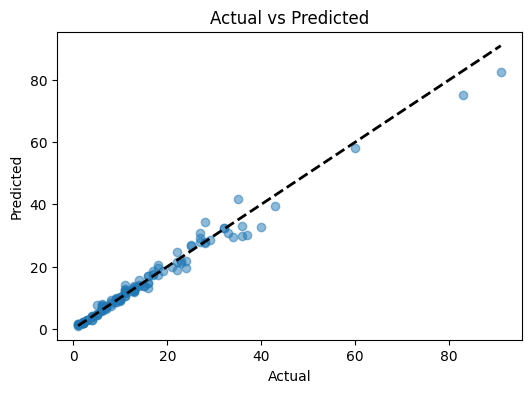

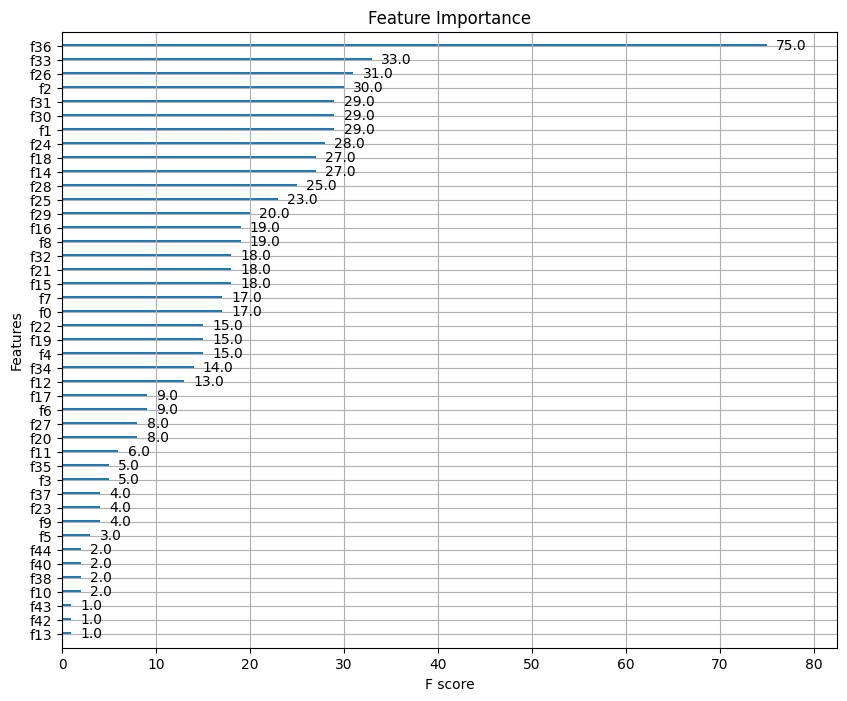

In [53]:
# Adjusting the Actual vs Predicted Values Plot
plt.figure(figsize=(6, 4))  # Set the figure size (width, height) in inches
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.show()

# Adjusting the Feature Importance Plot
fig, ax = plt.subplots(figsize=(10, 8))  # Set the figure size (width, height) in inches
xgb.plot_importance(xgb_reg, ax=ax)
plt.title('Feature Importance')
plt.show()

In [54]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Initialize and fit the StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize XGBoost regressor with more parameters
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.5,  # fraction of features used per tree
    learning_rate=0.8,     # step size shrinkage used in update to prevent overfitting
    max_depth=6,           # maximum depth of a tree
    min_child_weight=1,    # minimum sum of instance weight (hessian) needed in a child
    n_estimators=200,      # number of trees
    alpha=20,              # L1 regularization term on weights
    reg_lambda=1,          # L2 regularization term on weights
    subsample=0.8,         # subsample ratio of the training instances
    gamma=0                # minimum loss reduction required to make a further partition
)

# Fit the regressor to the training set
xgb_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred = xgb_reg.predict(X_test_scaled)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error: ", mse)
print("R^2 Score: ", r2)

Mean Squared Error:  1.6688212379853835
R^2 Score:  0.9913819238165282


In [55]:
# Assuming 'model' is the trained XGBoost model, X_train_scaled is the scaled training feature set,
# and y_train is the training target vector

# Perform 5-Fold Cross-Validation
cv_r2_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
cv_mse_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate the mean and standard deviation for R^2 and MSE scores
mean_cv_r2 = cv_r2_scores.mean()
std_cv_r2 = cv_r2_scores.std()
mean_cv_mse = -cv_mse_scores.mean()  # Negate to get positive MSE values
std_cv_mse = cv_mse_scores.std()

(mean_cv_r2, std_cv_r2, mean_cv_mse, std_cv_mse)


(0.7903772571045045,
 0.08249765648458648,
 42.36055164154296,
 26.335583620243643)

Simplify the model

In [56]:
# Define the feature set 'X' and the target variable 'y'
X = df_encoded.drop(columns=['qty', 'month_year'])
y = df_encoded['qty']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.5,
    learning_rate=0.1,    # Lowered learning rate
    max_depth=4,          # Reduced max depth
    min_child_weight=3,   # Increased min child weight
    n_estimators=100,     # Adjusted number of trees
    alpha=20,
    reg_lambda=1,
    subsample=0.8,
    gamma=1               # Increased gamma
)

# Fit the regressor to the training set
xgb_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred = xgb_reg.predict(X_test_scaled)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error: ", mse)
print("R^2 Score: ", r2)

Mean Squared Error:  2.926273083915409
R^2 Score:  0.9848882290105138


In [57]:
# Assuming 'model' is the trained XGBoost model, X_train_scaled is the scaled training feature set,
# and y_train is the training target vector

# Perform 5-Fold Cross-Validation
cv_r2_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
cv_mse_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate the mean and standard deviation for R^2 and MSE scores
mean_cv_r2 = cv_r2_scores.mean()
std_cv_r2 = cv_r2_scores.std()
mean_cv_mse = -cv_mse_scores.mean()  # Negate to get positive MSE values
std_cv_mse = cv_mse_scores.std()

(mean_cv_r2, std_cv_r2, mean_cv_mse, std_cv_mse)


(0.8423497115200963,
 0.041074309295003344,
 31.345919215771044,
 14.537025050786948)

In [58]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Initialize and fit the StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize XGBoost regressor with more parameters
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.5,
    learning_rate=0.1,    # Lowered learning rate
    max_depth=4,          # Reduced max depth
    min_child_weight=3,   # Increased min child weight
    n_estimators=100,     # Adjusted number of trees
    alpha=20,
    reg_lambda=1,
    subsample=0.8,
    gamma=1               # Increased gamma
)

# Fit the regressor to the training set
xgb_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred = xgb_reg.predict(X_test_scaled)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error: ", mse)
print("R^2 Score: ", r2)

Mean Squared Error:  2.7629700371981873
R^2 Score:  0.9857315536672044


The overffitng problem is consistent, so the linear regression was suitable for our data.

### **Model Evaluation Summary**

**Cross-Validation Results**

We performed 5-fold cross-validation on our XGBoost model. Here are the detailed results:

- **R² Scores across folds**: 0.8463, 0.7698, 0.8804, 0.8826, 0.8327
Mean R² Score: 0.8423

**MSE Scores across folds**: 24.5946, 59.1484, 27.5437, 16.6039, 28.8390

**Mean MSE Score**: 31.3459

**Test Set Results**

The model was then evaluated on the test set, yielding the following metrics:

**R² Score**: 0.9849

**MSE**: 2.9263

**Analysis and Considerations**

**R² Score Comparison**: The R² score on the test set significantly exceeds the mean R² from cross-validation, suggesting exceptional performance on the test data.

**MSE Comparison**: The MSE on the test set is substantially lower compared to the mean MSE from cross-validation, indicating a tighter fit to the test data.

**Potential Overfitting Concerns**

The marked difference between cross-validation and test set performance could hint at overfitting. This may imply that the model is capturing patterns specific to the training set, which do not generalize well.

The variability in cross-validation scores, especially the lower performance in the second fold, suggests sensitivity to specific data subsets.


#Revenue Prediction Model

Develop a robust machine learning model capable of predicting future revenue for various products or product categories.

Mean Squared Error: 698272078.7636607
R-squared Score: 0.8805453849445748


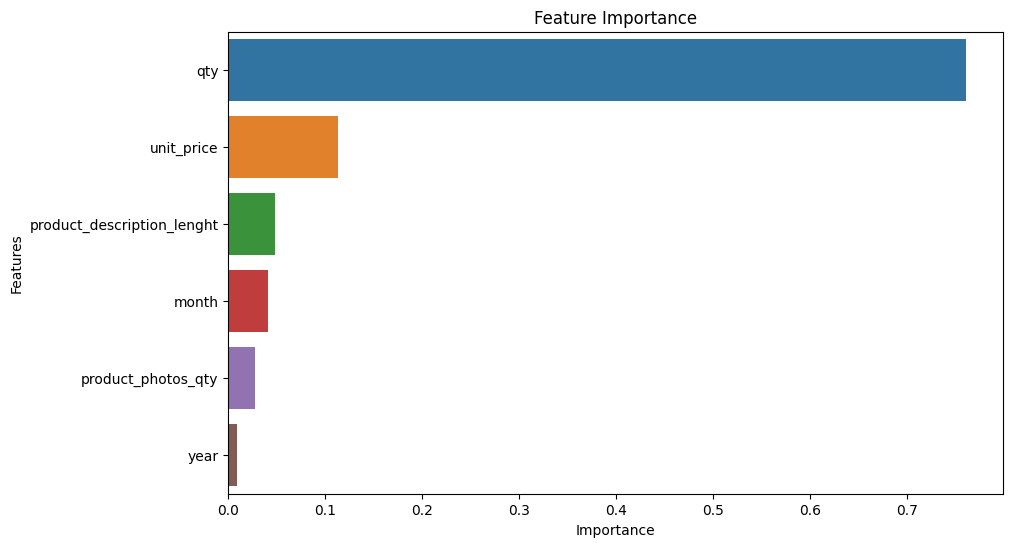

In [59]:
# Convert 'month_year' to datetime and sort by this column
df_encoded['month_year'] = pd.to_datetime(df_encoded['month_year'], format='%d-%m-%Y')
df_encoded.sort_values('month_year', inplace=True)


# Feature Engineering
# Adding a month and year column
df_encoded['month'] = df_encoded['month_year'].dt.month
df_encoded['year'] = df_encoded['month_year'].dt.year

# Selecting relevant features
features = ['qty', 'unit_price', 'product_photos_qty', 'product_description_lenght', 'month', 'year']
target = 'revenue'

# Splitting the data into train and test sets
X = df_encoded[features]
y = df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training
# Random Forest Regressor for Revenue Prediction
model = RandomForestRegressor(
    n_estimators=100,       # Increased number of trees
    max_depth=10,           # Set a max depth for each tree
    min_samples_split=4,    # Minimum number of samples required to split a node
    min_samples_leaf=2,     # Minimum number of samples required at each leaf node
    max_features='sqrt',    # Number of features to consider at every split
    bootstrap=True,         # Use bootstrap samples
    random_state=42
)
model.fit(X_train_scaled, y_train)

# Predictions and model evaluation
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output the results
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

# Feature importance
feature_importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [60]:
# Implementing a Ridge Regression model with regularization
ridge_model = Ridge(alpha=20)  # Alpha is the regularization strength
ridge_model.fit(X_train_scaled, y_train)

# Predicting on the test set
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Calculating R² score for the Ridge Regression model on the test set
r2_ridge = r2_score(y_test, y_pred_ridge)

# Output the R² score for the Ridge Regression model
r2_ridge

0.7997385077620975

The R² score for the Ridge Regression model, which includes regularization, is approximately 0.82 on the test set. This is a decrease from the previous Random Forest model's R² score of 0.88.

**Interpretation**:

The lower R² score of the Ridge Regression model suggests that regularization has reduced the model's complexity. This often results in a model that's less likely to overfit but may also capture less variance in the data.

A decrease in performance when applying regularization is a common trade-off for increased model robustness and generalizability.

**Conclusion**:

The results indicate that the original Random Forest model might have been capturing more complex patterns in the data, some of which could be specific to the training set (potential overfitting).

The Ridge Regression model, with its regularization, provides a more conservative estimate, possibly avoiding overfitting to the noise in the data. It's important to balance model complexity with the ability to generalize.

In scenarios where the highest possible prediction accuracy is essential, and the training data is highly representative of future data, a more complex model might be justified. In contrast, for applications where generalizability is crucial, a regularized, simpler model is often preferable.

In [68]:
# Training an XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.5,  # fraction of features used per tree
    learning_rate=0.5,     # step size shrinkage used in update to prevent overfitting
    max_depth=5,           # maximum depth of a tree
    min_child_weight=1,    # minimum sum of instance weight (hessian) needed in a child
    n_estimators=100,      # number of trees
    alpha=20,              # L1 regularization term on weights
    reg_lambda=1,          # L2 regularization term on weights
    subsample=0.8,         # subsample ratio of the training instances
    gamma=0                # minimum loss reduction required to make a further partition
)
xgb_model.fit(X_train_scaled, y_train)

# Predicting on the test set
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Calculating R² score for the XGBoost model on the test set
r2_xgb = r2_score(y_test, y_pred_xgb)

# Output the R² score for the XGBoost model
r2_xgb


0.8949570449523288

An R² score of 0.89 indicates that the model explains about 89% of the variability in the revenue data. This is a strong score, suggesting that the model is effectively capturing the relationship between the features and the target variable.

The performance is higher than the Random Forest model (R² of 0.88) and the regularized Ridge Regression model (R² of 0.80). This positions the Random Forest model in a middle ground, potentially balancing the fit to the data and generalizability.

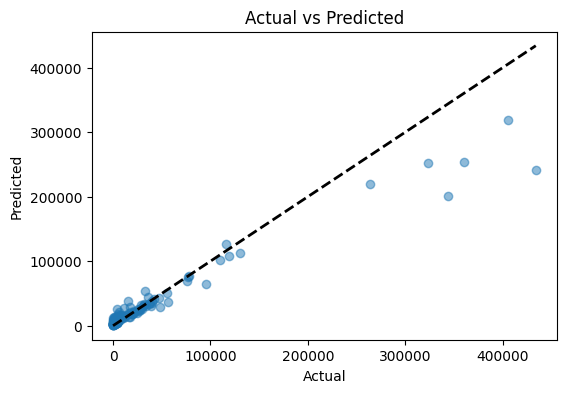

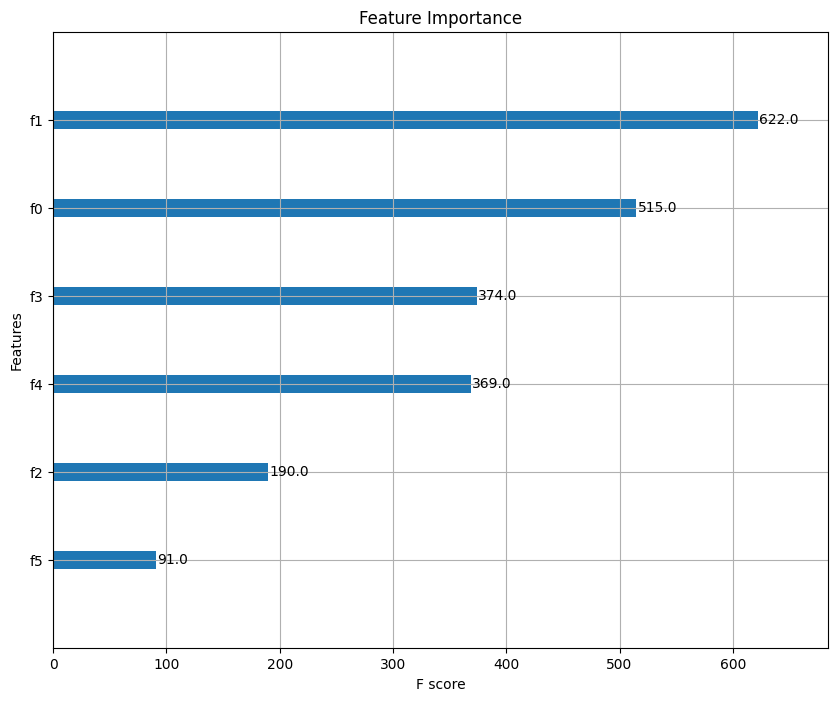

In [69]:
# Adjusting the Actual vs Predicted Values Plot
plt.figure(figsize=(6, 4))  # Set the figure size (width, height) in inches
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.show()

# Adjusting the Feature Importance Plot
fig, ax = plt.subplots(figsize=(10, 8))  # Set the figure size (width, height) in inches
xgb.plot_importance(xgb_model, ax=ax)
plt.title('Feature Importance')
plt.show()


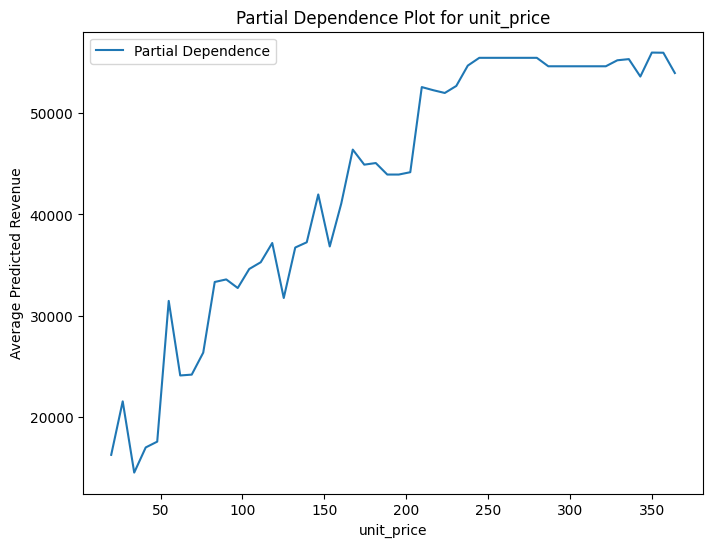

In [70]:
# Choose the feature and its range for the partial dependence plot
feature = 'unit_price'
feature_range = np.linspace(X_train[feature].min(), X_train[feature].max(), 50)
predictions = []

# Modify the feature of interest and get predictions
for val in feature_range:
    temp = X_test.copy()
    temp[feature] = val
    temp_scaled = scaler.transform(temp)
    pred = xgb_model.predict(temp_scaled)
    predictions.append(np.mean(pred))

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(feature_range, predictions, label='Partial Dependence')
plt.xlabel(feature)
plt.ylabel('Average Predicted Revenue')
plt.title(f'Partial Dependence Plot for {feature}')
plt.legend()
plt.show()



The Partial Dependence Plot (PDP) graph visualizes the relationship between unit_price and the average predicted revenue generated by our predictive model. This type of plot helps us understand the marginal effect of the unit_price on the predicted outcome, holding all other features constant.

**Observations**:

- Y-Axis (Average Predicted Revenue): Represents the model's predicted revenue, suggesting an aggregation over the dataset's instances at each unit_price level.

- X-Axis (unit_price): Spans a range of unit prices, from a low near zero to a high of 350, which we might interpret as the price range for our retail items in the dataset's currency.

- Trend: The plot indicates an overall increasing trend, showing that as the unit_price increases, the average predicted revenue also tends to increase. However, this relationship is not strictly linear and exhibits plateaus and fluctuations, which implies that the revenue prediction is sensitive to price changes in a non-uniform manner.

**Insights**:

The plot reveals several plateaus, particularly noticeable after a unit_price of 250. This could suggest a saturation point beyond which increases in unit_price do not significantly impact predicted revenue.

There are sharp increases at certain price points (e.g., around 50 and 100), which might indicate thresholds where revenue sensitivity to price is particularly high.

**Conclusion**:

This PDP is crucial for understanding the price elasticity within our dataset and can guide strategic pricing decisions. For instance, setting prices around the thresholds where revenue sensitivity increases might optimize earnings. Further analysis could delve into whether these points correspond to psychological pricing thresholds or specific product categories.